Danny Abraham & Jad Abi Zaki
<center><h1>CMPS 351</h1></center>
<center><h2>Assignment 11</h2></center>

In [1]:
import numpy as np
import numpy.linalg as la
from bunch import Bunch
import scipy.optimize
import matplotlib.pyplot as plt
from scipy.optimize import linprog as lp
import cvxpy as cvx
import math
from itertools import combinations
import scipy.linalg as la
from qcqp import *

## Planar Disk Contact 
---

for this to be feasible first we have the constraints 
$$ x \geq r$$
$$ x\leq 1-r$$

$$ y \geq r$$
$$ y\leq 1-r$$

where r is defined as a vector of radiuses of the diffrent disk in the problem and x and y are the cordinates of the centers of the circles

Also for this to be feasible we need to have the distance between the centers of any of the planar disks satisfy

$$ s_{ij} \geq r_i+r_j$$

which is equivlant to 

$$ s_{ij}^2 \geq (r_i+r_j)^2$$

Define $s_{ij}$ to be the distance between two circles, noting that the distance from any possible corner is satisfied anyway due to the x,y bounds above constraints. However, these distances will have to appear in the objective function. 

The objective function can be defined as the potential energy

$$ \min \frac{1}{2}k^t\Delta ^2_j$$

we can write $\Delta ^2_j$ using the x and y cordinates
$$ \Delta ^2_j = (x_i-x_j)^2+(y_i-y_j)^2$$

Finally we can formulate the problem in the following manner:

$$\min \qquad x^tB^tK_{ij}Bx + y^tB^tK_{ij}By + x^tC^tKCx + y^tC^tKCy $$
$$ subject \; to\; \begin{matrix} x \geq r \\   
                             x\leq 1-r \\  
                             y \geq r \\   
                             y\leq 1-r \\  
                             (Bx)^2 + (By)^2 \geq (B_1r)^2
                             \end{matrix} $$
                             
$B$ is defined to be a matrix that takes all possible combinations of the disks present to measure the distance between them.   
$B_1$ is defined as the combination of possible radiuses essentially the same but we don't want to subtract $x_j - x_i $ rather add $r_i + r_j$   
$C$ is the combination of the diskes with all possible corners   
$K_{ij}$ defines the elasticity constanct of the strings that connet all possible point if string does not exist $k =0$   
$K$ is the same but for the corners 

-------------------------------------------------
The Lagrangians can be seen as the contact force between the surfaces. With the force pointing away from the contact surface as expressed in the constraints. $\lambda$ in value should be equal to k since $f = k(\Delta J)$. Finally, the lagrangians can be seen the sensitivity of loosening or tightening a constraints. This makes sense to be equal to k since if we can decrease the length of this string by 1 we will decrease the value of the function by k.

----------------------------------------------------
$$ L(x, \lambda) = \frac{1}{2}x^tB^tK_{ij}Bx+\frac{1}{2}y^tB^tK_{ij}By + \frac{1}{2}x^tC^t K Cx+\frac{1}{2}y^tC^t K Cy - \lambda_{1x}(x - r) - \lambda_{1y}(y - r) + \lambda_{2x}(x+r - 1)+\lambda_{2y}(y+r - 1) + \lambda_3((Bx)^2+(By)^2-(B_1r)^2)$$

KKT conditions

The Gradient of the Lagrangian with respect to the primal variables vanishes

$$\nabla L_x = B^tK_{ij}Bx +C^tKCx - \lambda_{1x} + \lambda_{2x} + 2\lambda_3(B^tIBx) = 0$$
$$\nabla L_y = B^tK_{ij}By +C^tKCy - \lambda_{1y} + \lambda_{2y} + 2\lambda_3(B^tIBy) = 0$$

The constrains are satisfied

$$(Bx)^2 + (By)^2 \geq (B_1r)^2$$

$$ x \geq r$$
$$ x\leq 1-r$$

$$ y \geq r$$
$$ y\leq 1-r$$

Dual constraints

$$\lambda_{1x} \geq 0 $$
$$\lambda_{2x} \geq 0 $$

$$\lambda_{1y} \geq 0 $$
$$\lambda_{2y} \geq 0 $$

$$\lambda_{3} \geq 0 $$

Complementary constaints

$$\lambda_i f_i(x) \; were\;f_i \in\; to\;the\;constraint\; set $$

In [2]:
def Make_matrix():
    x = range(4)
    x1 = np.array(list(combinations(x,2)))    
    
    A = np.zeros([6,4])
    D = np.zeros([6,4])
    for i in range(6):
        A[i][x1[i][0]] = 1
        A[i][x1[i][1]] = -1
        D[i][x1[i][0]] = 1
        D[i][x1[i][1]] = 1
        
            
    return A,D

In [3]:
objMatrix, RadiusMatrix = Make_matrix()

In [4]:
objMatrix

array([[ 1., -1.,  0.,  0.],
       [ 1.,  0., -1.,  0.],
       [ 1.,  0.,  0., -1.],
       [ 0.,  1., -1.,  0.],
       [ 0.,  1.,  0., -1.],
       [ 0.,  0.,  1., -1.]])

In [5]:

x = cvx.Variable((4))
y = cvx.Variable((4))
n = 4
r = np.array([0.1,0.1,0.1,0.15])
k_ij = np.array([10,0,1,10,10,1])

k_1 = np.array([0,1,0,0])
k_2 = np.array([0,0,0,10])
k_3 = np.array([0,0,1,0])
k_4 = np.array([1,0,0,0])

In [6]:
print(objMatrix)
print(RadiusMatrix)

[[ 1. -1.  0.  0.]
 [ 1.  0. -1.  0.]
 [ 1.  0.  0. -1.]
 [ 0.  1. -1.  0.]
 [ 0.  1.  0. -1.]
 [ 0.  0.  1. -1.]]
[[1. 1. 0. 0.]
 [1. 0. 1. 0.]
 [1. 0. 0. 1.]
 [0. 1. 1. 0.]
 [0. 1. 0. 1.]
 [0. 0. 1. 1.]]


In [15]:
constraints_x1 = [x <= 1 - r] ## constraint 1
constraints_y1 = [y <= 1 - r] ## constraint 2
constraints_x2 = [x >= r] ## constraint 1
constraints_y2 = [y >= r] ## constraint 2



constraints_1 = [cvx.square((objMatrix*x)) + cvx.square((objMatrix*y)) >= (RadiusMatrix@r)**2]

constraints = constraints_x1 + constraints_x2 + constraints_y1 + constraints_y2 \
                       + constraints_1

In [16]:
corner_x = np.array([0,0,1,1])
corner_y = np.array([0,1,0,1])
t = np.ones(4)
I = np.identity(4)
u = 10**-6
side =  cvx.quad_form((t*x[0]-corner_x),np.diag(k_1))+cvx.quad_form(t*y[0]-corner_y,np.diag(k_1)) +\
        cvx.quad_form((t*x[1]-corner_x),np.diag(k_2))+cvx.quad_form(t*y[1]-corner_y,np.diag(k_2)) +\
        cvx.quad_form((t*x[2]-corner_x),np.diag(k_3))+cvx.quad_form(t*y[2]-corner_y,np.diag(k_3)) +\
        cvx.quad_form((t*x[3]-corner_x),np.diag(k_4))+cvx.quad_form(t*y[3]-corner_y,np.diag(k_4)) 

inter = cvx.quad_form((objMatrix*x),np.diag(k_ij)) + cvx.quad_form((objMatrix*y),np.diag(k_ij))


obj = cvx.Minimize(inter/2 + side/2)

prob = cvx.Problem(obj,constraints)

In [17]:
q = qcqp.QCQP(prob)

In [18]:
q.suggest(SPECTRAL, solver=cvx.CVXOPT)

(39.30350215215117, 0.9630909453172082)

In [19]:
f_cd, v_cd = q.improve(COORD_DESCENT)

In [20]:
print(x.value)
print(y.value)

[[0.5913065 ]
 [0.78679925]
 [0.72757894]
 [0.47824496]]
[[0.72061502]
 [0.76283568]
 [0.57180439]
 [0.49764173]]


(-0.001, 1.001)

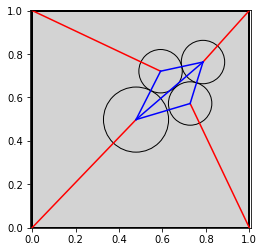

In [96]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

square = plt.Rectangle((0,0),1,1, color = 'lightgrey',fill = True)
ax.add_artist(square)

square1 = plt.Rectangle((0,0),1,1, color = 'k',linewidth = 2,fill = False)
ax.add_artist(square1)

circle1=plt.Circle((x.value[0],y.value[0]),r[0] , color='black', fill = False)
ax.add_artist(circle1)

circle2=plt.Circle((x.value[1],y.value[1]),r[1] , color='black', fill = False)
ax.add_artist(circle2)

circle3=plt.Circle((x.value[2],y.value[2]),r[2] , color='black', fill = False)
ax.add_artist(circle3)

circle4=plt.Circle((x.value[3],y.value[3]),r[3] , color='black', fill = False)
ax.add_artist(circle4)



plt.plot(np.array([1,x.value[2]]), np.array([0,y.value[2]]).reshape(2), c = 'r')
plt.plot(np.array([1,x.value[1]]), np.array([1,y.value[1]]).reshape(2), c = 'r')
plt.plot(np.array([0,x.value[3]]), np.array([0,y.value[3]]).reshape(2), c = 'r')
plt.plot(np.array([0,x.value[0]]), np.array([1,y.value[0]]).reshape(2), c = 'r')

plt.plot(np.array([x.value[1],x.value[0]]).reshape(2), np.array([y.value[1],y.value[0]]).reshape(2), c = 'b')
plt.plot(np.array([x.value[3],x.value[0]]).reshape(2), np.array([y.value[3],y.value[0]]).reshape(2), c = 'b')
plt.plot(np.array([x.value[1],x.value[2]]).reshape(2), np.array([y.value[1],y.value[2]]).reshape(2), c = 'b')
plt.plot(np.array([x.value[3],x.value[2]]).reshape(2), np.array([y.value[3],y.value[2]]).reshape(2), c = 'b')
plt.plot(np.array([x.value[3],x.value[1]]).reshape(2), np.array([y.value[3],y.value[1]]).reshape(2), c = 'b')
plt.plot(x.value[3],x.value[3] )
ax.axis('scaled')
ax.set_xlim([-0.01,1.01])
ax.set_ylim([-0.001,1.001])

## Trust Region Constraint 
---

#### Non-convex Problem
---
$$ \underset{x}{minimize} \qquad p^tHp + 2g^tp$$
$$ \textit{subject to} \qquad p^tp \le \Delta ^2$$

#### Lagrangian of Problem
---
$$ L(p, \lambda) = p^tHp + 2g^tp + \lambda (p^tp - \Delta^2)$$
#### Finding the Dual
---
$$ L(p, \lambda) = p^tHp + 2g^tp + \lambda p^tp  - \lambda\Delta^2$$
$$...$$
$$ L(p, \lambda) = p^t(H + \lambda \textbf{I})p + \underbrace{2g^tp - \lambda\Delta^2}_{maximize} $$
$$...$$
$$$$
$$ $$

Thus the Lagrangian can be written as a quadratic functionin terms of p:

$$\therefore H + \lambda \textbf{I} \succcurlyeq 0\qquad$$     
$$$$
$$\nabla_p L(p, \lambda) = 2(H + \lambda \textbf{I})p + 2g^t = 0$$
$$$$
$$ \therefore p = -\frac{(2g^t)}{2(H + \lambda \textbf{I})} = -(H+\lambda \textbf{I})^{-1}g$$
Replace in Lagrangian:$$ (-(H+\lambda \textbf{I})^{-1}g)^t(H + \lambda \textbf{I})(-(H+\lambda \textbf{I})^{-1}g) +2g^t(-(H+\lambda \textbf{I})^{-1}g) - \lambda\Delta^2$$
$$\Rightarrow \qquad-g^t(H + \lambda\textbf{I})^{-1}g  - \lambda\Delta^2 $$
$$ \Rightarrow\qquad  \underset{x} {maximize} \qquad  -g^t(H + \lambda\textbf{I})^{-1}g  - \lambda\Delta^2 $$
$$\qquad\qquad\textit{subject to}\qquad\qquad\qquad   H + \lambda \textbf{I} \succcurlyeq 0\qquad$$

#### Eigendecomposition
---
$$ (H + \lambda I)^{-1} = (Q^t( \mathbf{ \Lambda } + \lambda I)Q)^{-1}$$
$$ \qquad\qquad= Q^t(\mathbf{ \Lambda} + \lambda\mathbf{I})^{-1}Q $$
$$ Where:\;  \mathbf{ \Lambda } = diag(\lambda_1,\lambda_2, \lambda_3,...) $$ 
$$\qquad\qquad (\mathbf{ \Lambda }+ \lambda I)^{-1} = \frac{1}{\lambda_i + \lambda}  \qquad at\;each\;i$$
$$ (H + \lambda I)^{-1} = \frac{q^tq}{\lambda_i +\lambda}$$
$$ \Rightarrow\qquad \underset{x}{maximize} - \sum^{n}_{i = 1}{ \frac{(q_i^tg)^2}{\lambda_i + \lambda}}- \lambda\Delta^2$$
$$\textit{subject to}\qquad \lambda \ge -\lambda_{min}(H)$$

#### Pseudo Code
---
> $\textit{for} \; i = 1... m:$
>>Get the improving step by solving trust-region sub-problem
>>> Factor $H + \lambda_i $   
>>>Solve $I = Q^tQ $
>>> find the max of the dual    
>>> Using the multipliers we can find x by solving the set of linear equations       

>>$\rho=\frac{f(x^k)-f(x^k+p^k)}{m_k(0)-m_k(p^k)}$        
>> if $\rho < 0.25$, $\Delta_{k+1}$ is reduced and step rejected        
>> if $\rho > 0.75$, $\Delta_{k+1}$ is enlarged and step is accepted      
>> otherwise keep same Trust region and take step

We have a pareto optimal function, with $\alpha$ as the regularization parameter. We have 2 functions that we need to minimize that in essense are based on if one wants to more accuratly estimate the function values $\|Qu-d\|$ or if one wants the interval between the partitons which represent $c$ to be precisie as they were taken by measurments which represent $\|c-c^0\|$ where $c^0$ represents the supposed intervals at which it was taken.

## Gauss-Newton Method for a PDE-Constrained Problem
---

We have a pareto optimal function, with $\alpha$ as the regularization parameter. We have 2 functions that we need to minimize that in essense are based on if one wants to more accuratly estimate the function values $\|Qu-d\|$ or if one wants the interval between the partitons which represent $c$ to be precisie as they were taken by measurments which represent $\|c-c^0\|$ where $c^0$ represents the supposed intervals at which it was taken. Finally, $A(c)u= w$ is an equality constraint in which you want the curvuture of the function to be accurately retrived.

$$ \min \frac{1}{2}\|Qu - d\|^2 +\frac{\alpha}{2}\|c-c^0\|^2$$

$$ subject\;to\; A(c)u = w$$

$$L(u,c,\nu) = \frac{1}{2}\|Qu - d\|^2 +\frac{\alpha}{2}\|c-c^0\|^2 + \nu(A(c)u - w)$$

KKT conditions

$$ \nabla L_u = Q^tQu - 2d^tQ+\nu A = 0$$

$$ \nabla L_c = \alpha (c-c^o)+Gu = 0$$

Equality constraints are Satisfied:
$$A(c)u - w = 0$$


were $$G  = \frac{d}{dc}A(c)u $$  



Note since we have no inequality constraints we have no complementary slackness nor do we have dual constraints.

$$ J = \begin{bmatrix} Q^tQ & 0 & A^t\\ 0 & \alpha I & G^t \\ A & G & 0\end{bmatrix}$$

$$\begin{bmatrix} Q^tQ & 0 & A^t\\ 0 & \alpha I & G^t \\ A & G & 0\end{bmatrix} \begin{bmatrix} \Delta u\\ \Delta c\\ \Delta \nu\end{bmatrix} = \begin{bmatrix} L_ u\\ L_c\\ L_\nu\end{bmatrix}$$

More on G:

$$ \frac{1}{h^2}[c_iu_{i+1} - (c_i + c_{i-1})u_i +c_{i-1}u_{i-1} ] = w_i$$

or 

$$ \frac{1}{h^2}[(u_{i+1}- u_i)c_i  +(u_{i-1}- u_i)c_{i-1} ] = w_i$$

$$ G = \begin{bmatrix} u_{0}- u_1&u_{2}- u_1&0\\ 0& u_{1}- u_2  & u_{3}- u_2\end{bmatrix}$$

$$ G(u)c = w$$

The matrix G is a rectangular matrix. G will be a bidiagonal matrix which has p rows. p is the len(u) and n columns where n is the len (c)